In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
train_dir = "./ECG_DATA/train"
test_dir = "./ECG_DATA/test"


In [4]:
def get_subfolders_and_image_counts(directory):
    subfolders = {}
    for subdir, dirs, files in os.walk(directory):
        if dirs:
            for folder in dirs:
                folder_path = os.path.join(subdir, folder)
                num_images = len([file for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg'))])
                subfolders[folder] = num_images
    return subfolders

train_subfolders = get_subfolders_and_image_counts(train_dir)
test_subfolders = get_subfolders_and_image_counts(test_dir)

In [5]:
print("Training Subfolders and Image Counts:")
for folder, count in train_subfolders.items():
    print(f"{folder}: {count} images")

print("\nTest Subfolders and Image Counts:")
for folder, count in test_subfolders.items():
    print(f"{folder}: {count} images")

Training Subfolders and Image Counts:
ECG Images of Patient that have abnormal heartbeat (233x12=2796): 699 images
Normal Person ECG Images (284x12=3408): 852 images
ECG Images of Myocardial Infarction Patients (240x12=2880): 956 images
ECG Images of Patient that have History of MI (172x12=2064): 516 images

Test Subfolders and Image Counts:
ECG Images of Patient that have abnormal heartbeat (233x12=2796): 233 images
Normal Person ECG Images (284x12=3408): 284 images
ECG Images of Myocardial Infarction Patients (240x12=2880): 239 images
ECG Images of Patient that have History of MI (172x12=2064): 172 images


In [6]:
def plot_images_from_subfolders(directory, subfolders):
    for folder in subfolders:
        folder_path = os.path.join(directory, folder)
        image_files = [file for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg'))][:10]  # Get 10 images
        print(f"\nShowing 10 images from {folder}:")

        plt.figure(figsize=(20, 10))
        for i, image_file in enumerate(image_files):
            img_path = os.path.join(folder_path, image_file)
            img = mpimg.imread(img_path)
            plt.subplot(2, 5, i+1)
            plt.imshow(img)
            plt.axis('off')  

        plt.show()


Showing 10 images from ECG Images of Patient that have abnormal heartbeat (233x12=2796):


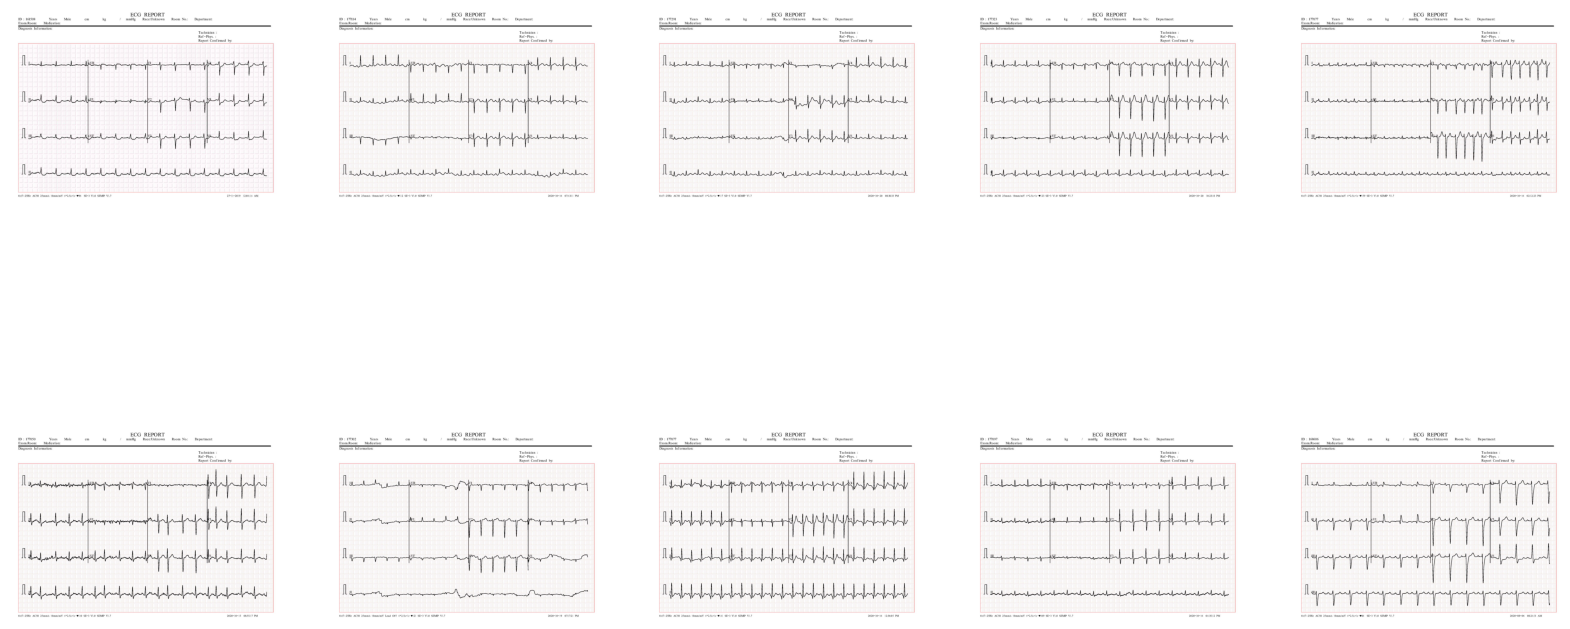


Showing 10 images from Normal Person ECG Images (284x12=3408):


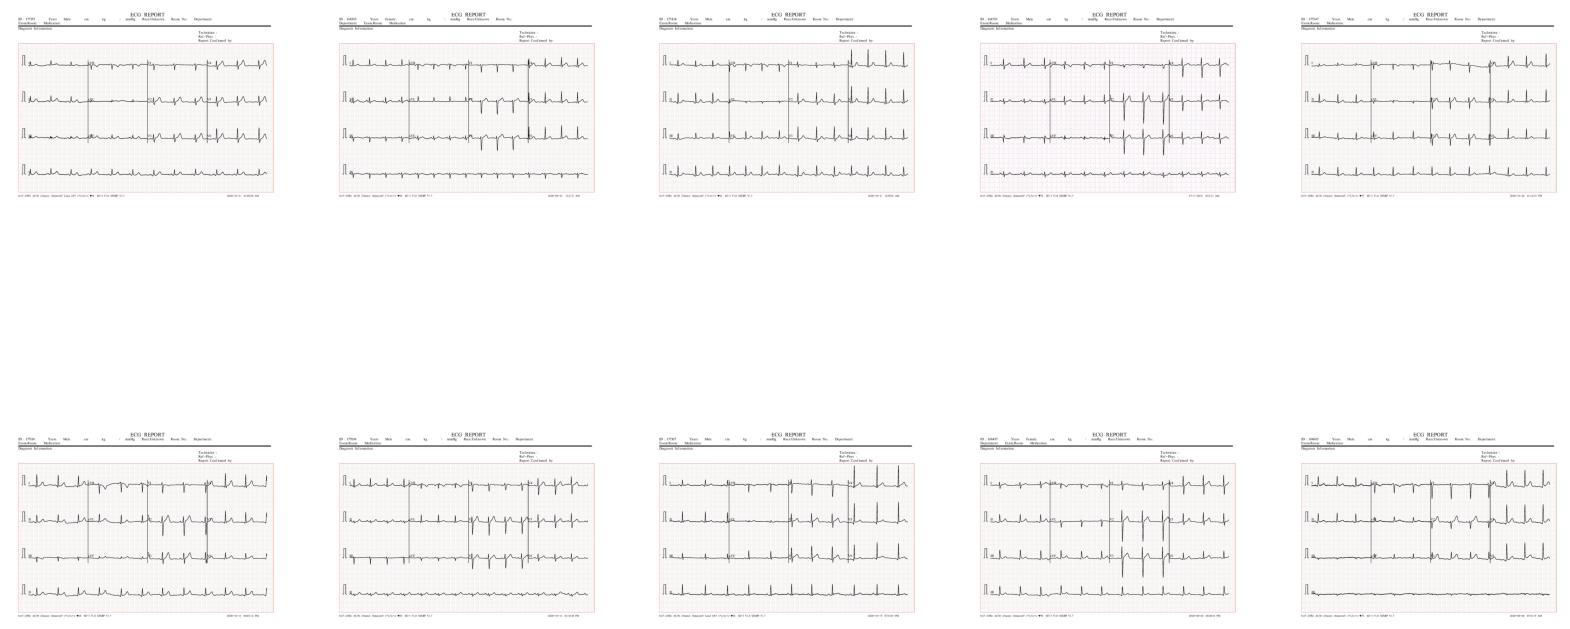


Showing 10 images from ECG Images of Myocardial Infarction Patients (240x12=2880):


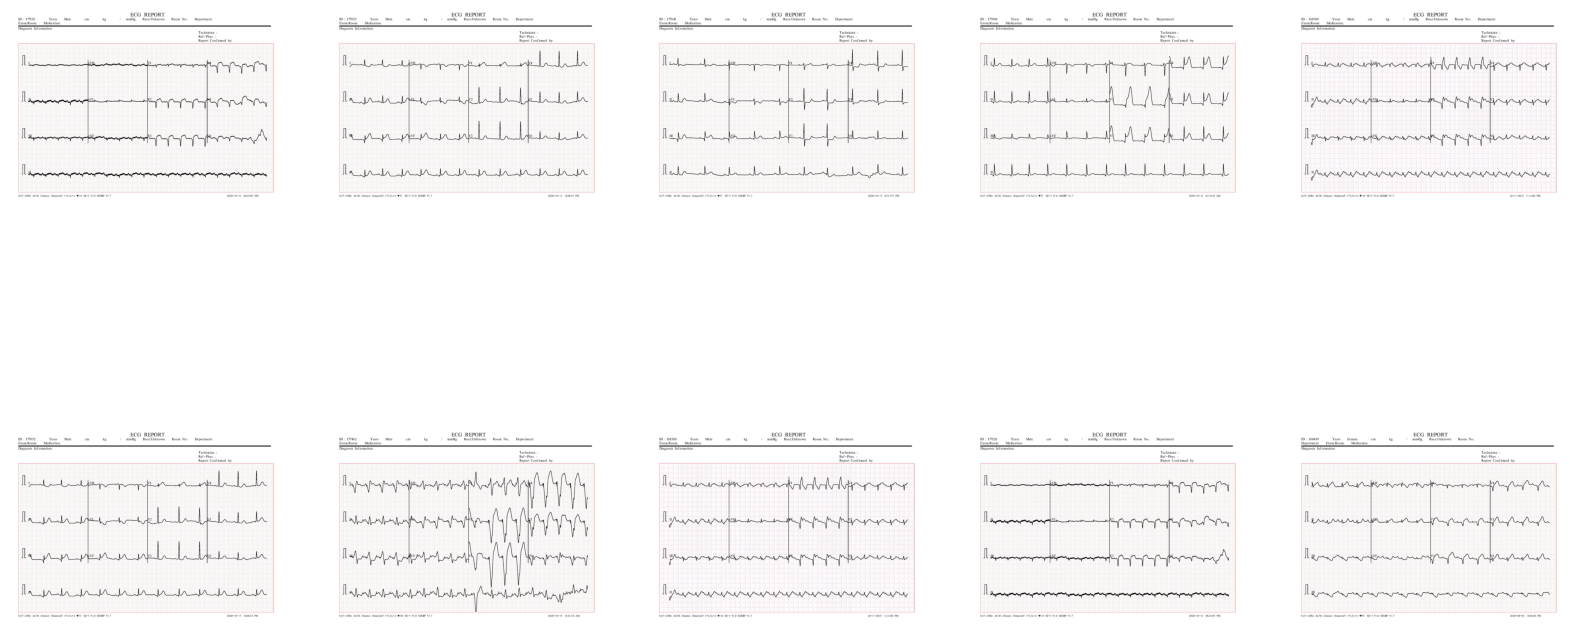


Showing 10 images from ECG Images of Patient that have History of MI (172x12=2064):


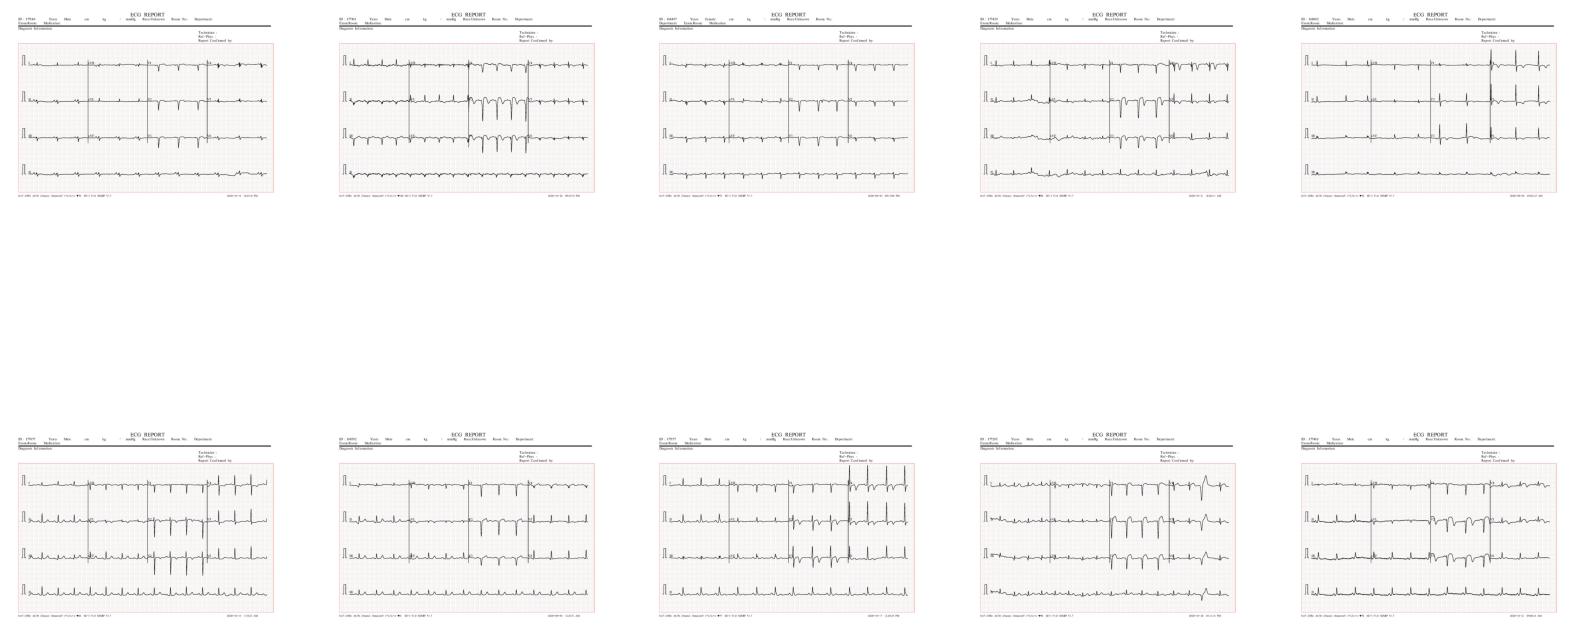

In [7]:
plot_images_from_subfolders(train_dir, train_subfolders)


Showing 10 images from ECG Images of Patient that have abnormal heartbeat (233x12=2796):


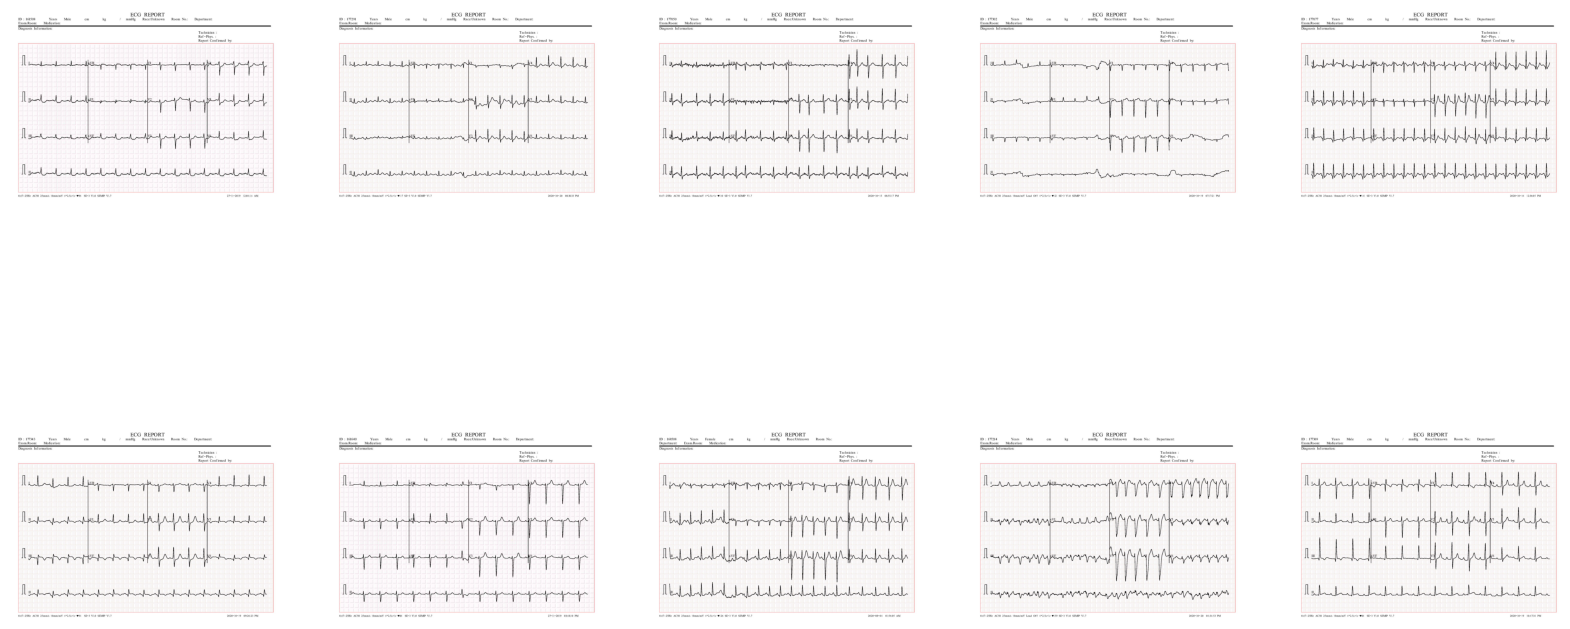


Showing 10 images from Normal Person ECG Images (284x12=3408):


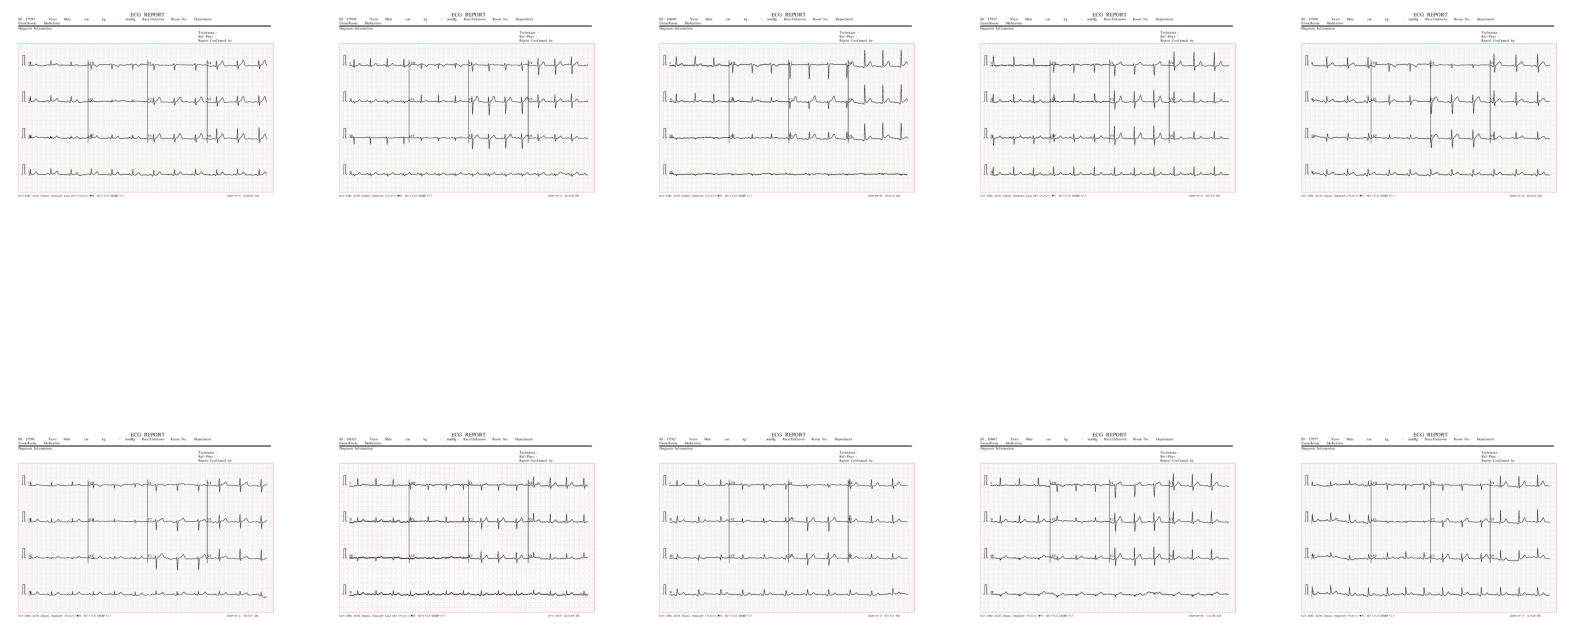


Showing 10 images from ECG Images of Myocardial Infarction Patients (240x12=2880):


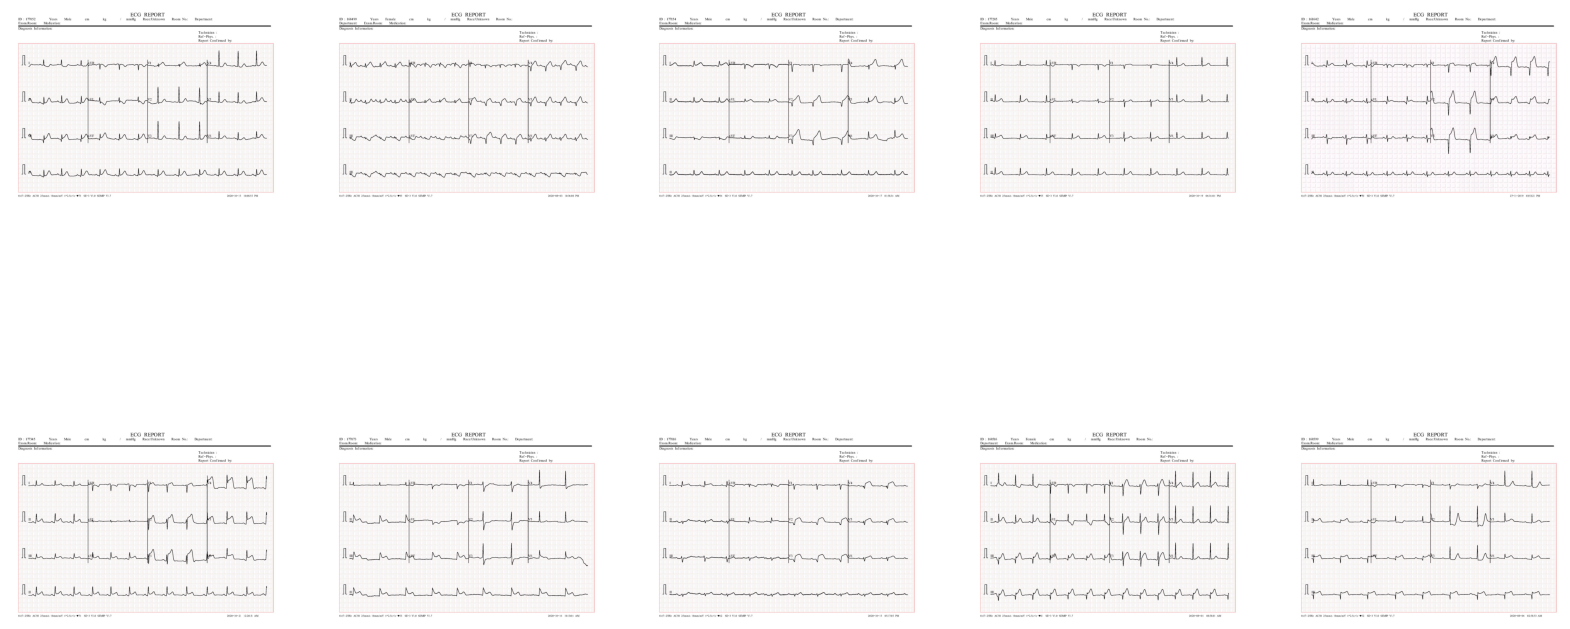


Showing 10 images from ECG Images of Patient that have History of MI (172x12=2064):


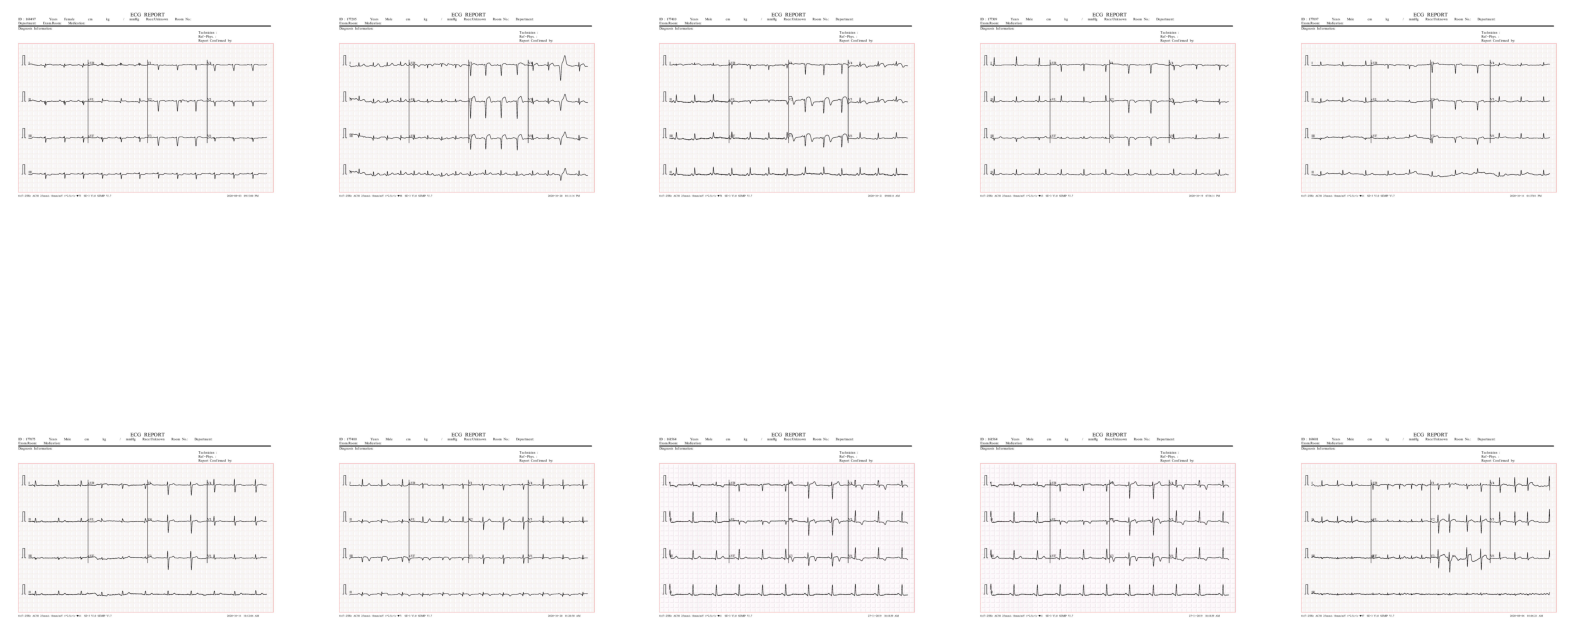

In [8]:

plot_images_from_subfolders(test_dir, test_subfolders)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    
    target_size=(224, 224),  
    batch_size=32,
    class_mode='categorical',
    subset='training'  
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

print("Class indices:", train_generator.class_indices)

Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.
Class indices: {'ECG Images of Myocardial Infarction Patients (240x12=2880)': 0, 'ECG Images of Patient that have History of MI (172x12=2064)': 1, 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)': 2, 'Normal Person ECG Images (284x12=3408)': 3}


In [11]:
import tensorflow as tf

In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPUs are available and memory growth is set.")
    except RuntimeError as e:
        print(e)

In [13]:
from tensorflow.keras import layers, models

In [14]:
from tensorflow.keras import layers, models, regularizers

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # 🔹 helps reduce overfitting

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),  # 🔹 stronger dropout deeper in network

    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # 🔹 prevents dense layer memorization

    layers.Dense(len(train_generator.class_indices), activation='softmax')
])


/Users/shreyashsingh/Documents/ECG Image/tf-env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,247,620 (84.87 MB)

 Trainable params: 22,246,660 (84.86 MB)

 Non-trainable params: 960 (3.75 KB)

In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10  
)

/Users/shreyashsingh/Documents/ECG Image/tf-env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 296s 4s/step - accuracy: 0.3044 - loss: 3.0882 - val_accuracy: 0.3229 - val_loss: 45.3356
Epoch 2/10
 1/75 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - accuracy: 0.2812 - loss: 2.9072

/Users/shreyashsingh/Documents/ECG Image/tf-env/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 207ms/step - accuracy: 0.2812 - loss: 2.9072 - val_accuracy: 0.3229 - val_loss: 45.9701
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.3539 - loss: 2.8449 - val_accuracy: 0.3160 - val_loss: 11.0788
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 238ms/step - accuracy: 0.2500 - loss: 3.1106 - val_accuracy: 0.3142 - val_loss: 11.3605
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 224s 3s/step - accuracy: 0.4058 - loss: 2.7006 - val_accuracy: 0.2899 - val_loss: 4.3234
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 211ms/step - accuracy: 0.4688 - loss: 2.5698 - val_accuracy: 0.2865 - val_loss: 4.3128
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - accuracy: 0.4229 - loss: 2.5384 - val_accuracy: 0.2309 - val_loss: 15.2256
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 194ms/step - accuracy: 0.3750 - loss: 2.6609 - val_accuracy: 0.2309 - val_loss: 15.1769
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - accuracy: 0.4606 - loss: 2.3676 - val_accuracy: 0.3212 -

In [18]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 606ms/step - accuracy: 0.2575 - loss: 32.8647

Test Accuracy: 0.2575431168079376


In [19]:
from tensorflow.keras.applications import VGG16

In [20]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [21]:
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(train_generator.class_indices), activation='softmax')  
])

In [22]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10  
)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 774s 10s/step - accuracy: 0.3224 - loss: 1.6403 - val_accuracy: 0.3733 - val_loss: 1.3108
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.5000 - loss: 1.2502 - val_accuracy: 0.4097 - val_loss: 1.3059
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 844s 11s/step - accuracy: 0.4263 - loss: 1.2780 - val_accuracy: 0.4826 - val_loss: 1.2220
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.3125 - loss: 1.3172 - val_accuracy: 0.4931 - val_loss: 1.2148
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 770s 10s/step - accuracy: 0.5297 - loss: 1.1568 - val_accuracy: 0.6059 - val_loss: 1.0527
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.5000 - loss: 1.1105 - val_accuracy: 0.5712 - val_loss: 1.0786
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 759s 10s/step - accuracy: 0.6097 - loss: 0.9888 - val_accuracy: 0.6597 - val_loss: 0.9167
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.6875 - loss: 0.9108 - val_accuracy: 0.6597

In [24]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 245s 8s/step - accuracy: 0.4591 - loss: 1.1208

Test Accuracy: 0.4590517282485962


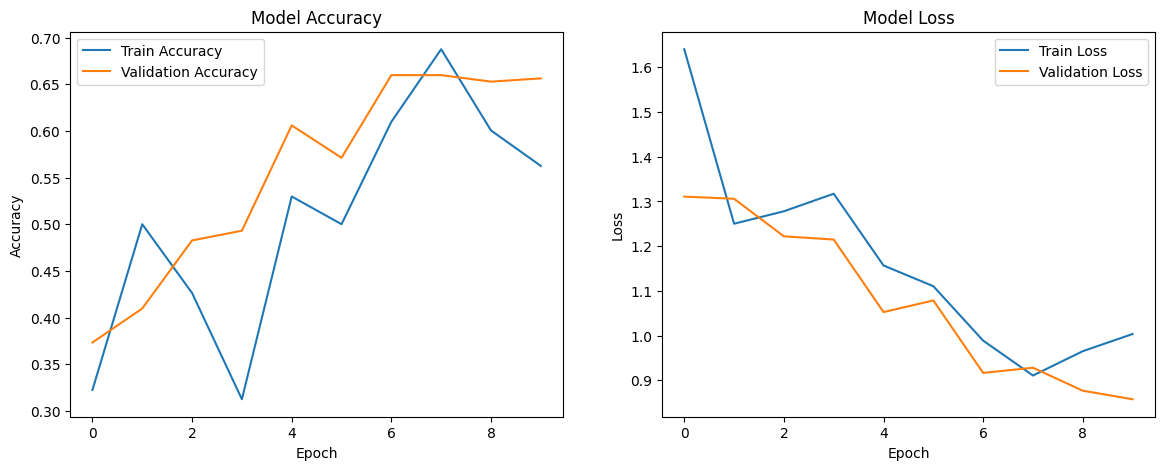

In [25]:
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

In [26]:
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

30/30 ━━━━━━━━━━━━━━━━━━━━ 252s 8s/step


In [27]:
from sklearn.metrics import confusion_matrix, classification_report

In [28]:
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[174   0  36  29]
 [120   0  34  18]
 [160   0  38  35]
 [190   0  47  47]]


In [29]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("\nClassification Report:")
print(report)


Classification Report:
                                                                  precision    recall  f1-score   support

      ECG Images of Myocardial Infarction Patients (240x12=2880)       0.27      0.73      0.39       239
     ECG Images of Patient that have History of MI (172x12=2064)       0.00      0.00      0.00       172
ECG Images of Patient that have abnormal heartbeat (233x12=2796)       0.25      0.16      0.20       233
                          Normal Person ECG Images (284x12=3408)       0.36      0.17      0.23       284

                                                        accuracy                           0.28       928
                                                       macro avg       0.22      0.26      0.20       928
                                                    weighted avg       0.24      0.28      0.22       928



/Users/shreyashsingh/Documents/ECG Image/tf-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/shreyashsingh/Documents/ECG Image/tf-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/shreyashsingh/Documents/ECG Image/tf-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

In [30]:
import seaborn as sns

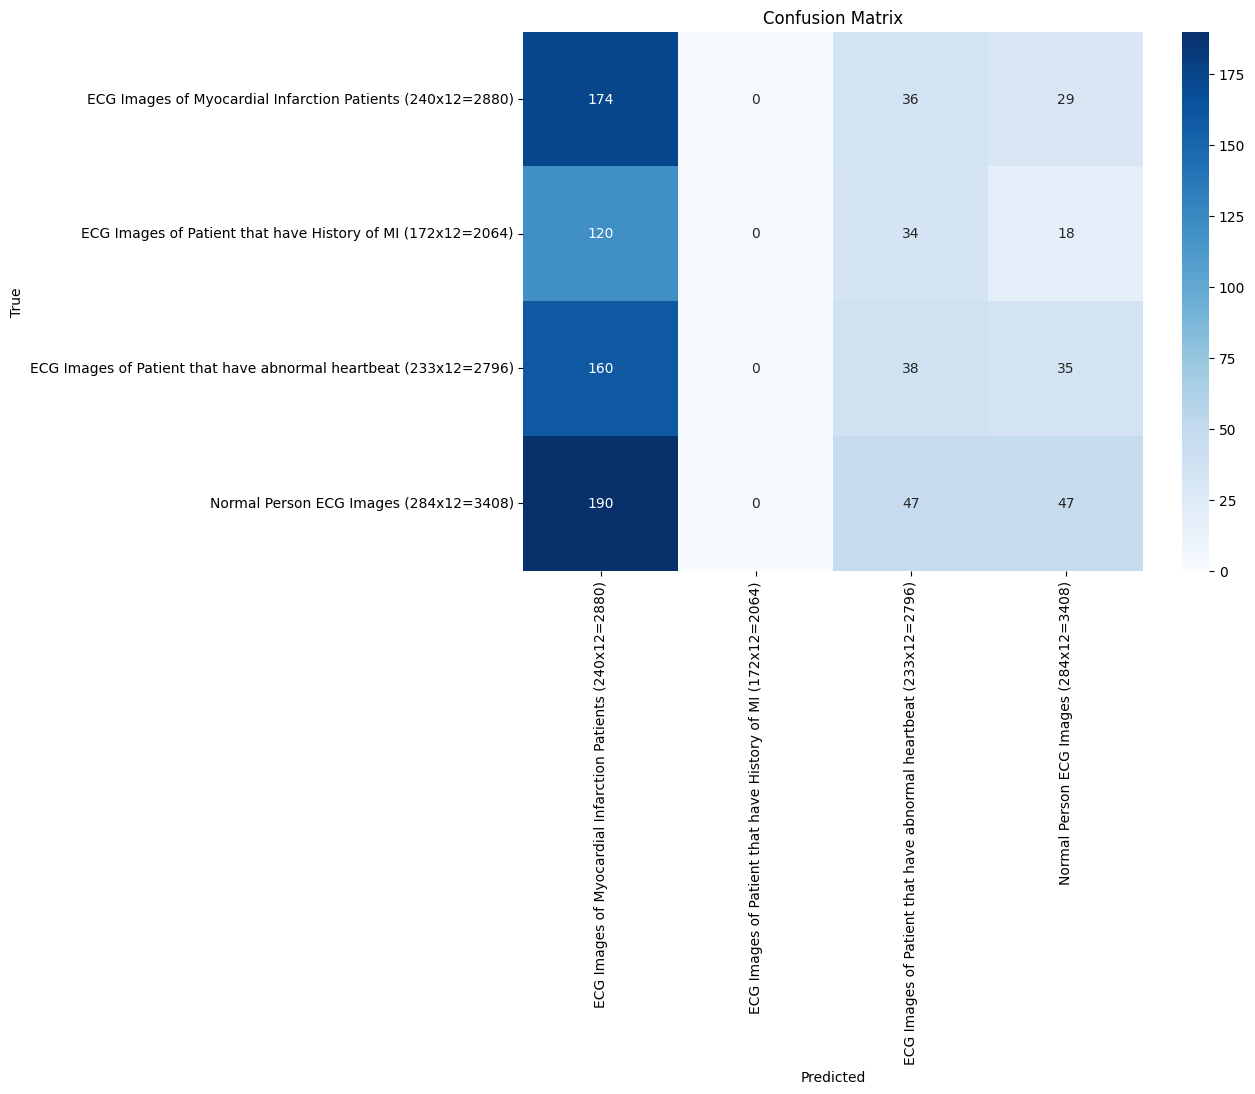

In [31]:
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm, class_labels)

In [32]:
model.save('ecg_image.h5')

In [20]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# 1️⃣ Load your saved model
model = load_model('ecg_image.h5')

# 2️⃣ Define your class labels (must match training)
classes = [
    'ECG Images of Myocardial Infarction Patients (240x12=2880)',
    'ECG Images of Patient that have History of MI (172x12=2064)',
    'ECG Images of Patient that have abnormal heartbeat (233x12=2796)',
    'Normal Person ECG Images (284x12=3408)'
]

# 3️⃣ Path to the image you want to test
img_path = r"./ECG_DATA/test/ECG Images of Patient that have abnormal heartbeat (233x12=2796)/HB(101).jpg"  # 🔹 Change to your image path

# 4️⃣ Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # shape (1, 224, 224, 3)
img_array = img_array / 255.0  # same rescale as training

# 5️⃣ Predict
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class = classes[predicted_class_index]

print(f"✅ Predicted Class: {predicted_class}")
print(f"🔹 Confidence Scores: {predictions[0]}")


1/1 [==============================] - 0s 224ms/step
✅ Predicted Class: ECG Images of Patient that have abnormal heartbeat (233x12=2796)
🔹 Confidence Scores: [0.01501608 0.10783058 0.8261494  0.05100389]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               3211392   
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 17926596 (68.38 MB)
Trainable params: 3211908 (12.25 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


2.13.0
